# Определение перспективного тарифа для телеком компании 

В распоряжении данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Шаг 1.  Общая информация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import math

In [2]:
users = pd.read_csv('/datasets/users.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
messages = pd.read_csv('/datasets/messages.csv')
internet = pd.read_csv('/datasets/internet.csv')
calls = pd.read_csv('/datasets/calls.csv')

In [3]:
print ('\033[1m' + 'Вывод метода info() для таблицы users' + '\033[0m')
users.info()
print ('\033[1m' + 'Вывод метода info() для таблицы messages' + '\033[0m')
messages.info()
print ('\033[1m' + 'Вывод метода info() для таблицы internet' + '\033[0m')
internet.info()
print ('\033[1m' + 'Вывод метода info() для таблицы calls' + '\033[0m')
calls.info()

Вывод метода info() для таблицы users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
Вывод метода info() для таблицы messages
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
Вывод метода info() для таблицы internet
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null 

In [4]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [5]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [6]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


### Вывод
Представлено 5 таблиц, пропуски в данных имеются только в одной таблице, убирать которые необязательно, т.к. этот столбец не используется в дальнейшем анализе.

## Шаг 2. Подготовка данных

In [7]:
internet.drop('Unnamed: 0', axis = 1, inplace = True)

In [8]:
print(users.duplicated().sum())
print(tariffs.duplicated().sum())
print(messages.duplicated().sum())
print(internet.duplicated().sum())
print(calls.duplicated().sum())

0
0
0
0
0


In [9]:
tariffs = tariffs.rename(columns ={'tariff_name' : 'tariff'})

In [10]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = calls['duration'].astype('int64')
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].astype('int64')
calls['user_id'] = calls['user_id'].astype('int64')
internet['user_id'] = internet['user_id'].astype('int64')
messages['user_id'] = messages['user_id'].astype('int64')

### Вывод
Удален неизвестный столбец в таблице интернет, переименован столбце в таблице тарифов для дальнейшего объединения таблиц, значения длительности звонков и использованного трафика округлены в большую сторону для более правильных расчетов. Звонки, длительностью 0 секунд оставлены в таблице, т.к. для дальнейшего анализа дохода нужна суммарная длительность звонков для пользователя, а не их количество и удаление этих звонков никак на него не повлияет

In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.2+ MB


In [12]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format ='%Y-%m-%d')
calls['month'] = calls['call_date'].dt.month
calls_pivot = calls.pivot_table(index = ('user_id', 'month'), values = 'duration', aggfunc = ('sum','count')).reset_index()
display(calls_pivot)
calls_pivot = calls_pivot.rename(columns = {'sum' : 'calls_duration', 'count' : 'calls_quantity'})

,user_id,month,count,sum
0,1000,5,22,159
1,1000,6,43,172
2,1000,7,47,340
3,1000,8,52,408
4,1000,9,58,466
...,...,...,...,...
3169,1498,10,41,247
3170,1499,9,9,70
3171,1499,10,68,449
3172,1499,11,74,612


In [13]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format ='%Y-%m-%d')
messages['month'] = messages['message_date'].dt.month
messages_pivot = messages.pivot_table(index = ('user_id', 'month'), values = 'message_date', aggfunc ='count').reset_index()
display(messages_pivot)
messages_pivot = messages_pivot.rename(columns = {'message_date' : 'message_quantity'})

,user_id,month,message_date
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [14]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format ='%Y-%m-%d')
internet['month'] = internet['session_date'].dt.month
internet_pivot = internet.pivot_table(index = ('user_id', 'month'), values = 'mb_used', aggfunc ='sum').reset_index()
display(internet_pivot)

,user_id,month,mb_used
0,1000,5,2256
1,1000,6,23257
2,1000,7,14016
3,1000,8,14070
4,1000,9,14581
...,...,...,...
3198,1498,10,20604
3199,1499,9,1848
3200,1499,10,17809
3201,1499,11,17984


In [15]:
internet_pivot.info()
messages_pivot.info()
calls_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 3 columns):
user_id    3203 non-null int64
month      3203 non-null int64
mb_used    3203 non-null int64
dtypes: int64(3)
memory usage: 75.2 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2717 entries, 0 to 2716
Data columns (total 3 columns):
user_id             2717 non-null int64
month               2717 non-null int64
message_quantity    2717 non-null int64
dtypes: int64(3)
memory usage: 63.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3174 entries, 0 to 3173
Data columns (total 4 columns):
user_id           3174 non-null int64
month             3174 non-null int64
calls_quantity    3174 non-null int64
calls_duration    3174 non-null int64
dtypes: int64(4)
memory usage: 99.3 KB


In [16]:
it_1 = calls_pivot.merge(internet_pivot, on =['user_id', 'month'], how = 'outer')

In [17]:
it_2 = it_1.merge(messages_pivot, on =['user_id', 'month'], how = 'outer')

In [18]:
it_3 = it_2.merge(users, on ='user_id', how = 'outer')

In [19]:
data = it_3.merge(tariffs, on = 'tariff', how ='outer')

In [20]:
data['calls_duration'].fillna(0, inplace =True)
data['mb_used'].fillna(0, inplace =True)
data['message_quantity'].fillna(0, inplace =True)
data['calls_duration'] = data['calls_duration'].apply(np.ceil)
data['calls_duration'] = data['calls_duration'].astype('int64')
data['mb_used'] = data['mb_used'].apply(np.ceil)
data['mb_used'] = data['mb_used'].astype('int64')
data['message_quantity'].astype('int64')

0       22
1       60
2       75
3       81
4       57
        ..
3211    32
3212    21
3213    20
3214    35
3215     0
Name: message_quantity, Length: 3216, dtype: int64

In [21]:
data['month'].fillna(12, inplace = True) # 2 пользователя, которые подключились и прекратили пользоваться тарифом в декабре, не совершив каких-либо действий.

In [22]:
data['gain'] = (data['rub_monthly_fee'] + 
                    np.where(data['calls_duration']-data['minutes_included']>0, (data['calls_duration']-data['minutes_included'])*data['rub_per_minute'], 0) + 
                    np.where(data['message_quantity']-data['messages_included']>0, (data['message_quantity']-data['messages_included'])*data['rub_per_message'], 0) + 
                    np.where(data['mb_used']-data['mb_per_month_included']>0, ((data['mb_used']-data['mb_per_month_included'])/1024)*data['rub_per_gb'], 0)
                   )

In [23]:
display(data.head())

,user_id,month,calls_quantity,calls_duration,mb_used,message_quantity,age,churn_date,city,first_name,...,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gain
0,1000,5.0,22.0,159,2256,22.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,43.0,172,23257,60.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,47.0,340,14016,75.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,52.0,408,14070,81.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,58.0,466,14581,57.0,52,NaN,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30720,3000,1950,150,1,1,1950.0


### Вывод
Искомые значения рассчитаны и добавлены в соединенную таблицу

## Шаг 3. Анализ данных


In [24]:
data[['calls_duration', 'mb_used', 'message_quantity']].describe()

,calls_duration,mb_used,message_quantity
count,3216.000000,3216.000000,3216.000000
mean,450.964241,17216.871580,38.257463
std,242.096312,7588.071848,36.149684
min,0.000000,0.000000,0.000000
25%,282.000000,12496.250000,9.000000
50%,443.000000,16962.000000,30.000000
75%,589.000000,21446.000000,57.000000
max,1673.000000,49789.000000,224.000000


In [25]:
data_pivot = data.pivot_table(index = ['tariff', 'month'], values = ('calls_duration', 'message_quantity', 'mb_used', 'gain')).reset_index()
display(data_pivot)

,tariff,month,calls_duration,gain,mb_used,message_quantity
0,smart,1.0,203.852941,702.556296,8524.441176,18.235294
1,smart,2.0,298.689655,804.337689,11611.396552,24.086207
2,smart,3.0,390.051948,1118.382508,15123.857143,31.857143
3,smart,4.0,367.133929,922.340472,13479.482143,30.741071
4,smart,5.0,387.361702,1146.921930,15825.198582,33.773050
5,smart,6.0,395.640244,1149.579697,15814.768293,33.402439
6,smart,7.0,408.353234,1168.063666,15763.512438,33.751244
7,smart,8.0,421.468085,1258.498005,16632.174468,33.638298
8,smart,9.0,428.611538,1199.072506,16324.526923,33.638462
9,smart,10.0,426.136054,1304.842315,16778.564626,33.765306


In [26]:
print(data_pivot[['calls_duration','mb_used','message_quantity']].mean())

calls_duration        441.111980
mb_used             16641.509663
message_quantity       37.541620
dtype: float64


### Вывод
По анализу среднего объема пользования услуг наблюдается небольшой тренд на увеличение количества к декабрю, что может быть связано с увеличением числа пользователей.

In [27]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

In [28]:
def stat(data, column):
    mean = data[column].mean()
    print('среднее', mean)
    variance = np.var(data[column])
    print('дисперсия =', variance)
    standard_dev = np.std(data[column], ddof = 1)
    print('стандартное отклонение =', standard_dev)
    data[column].hist(bins = 20)

среднее 417.747533632287
дисперсия = 36265.12415310985
стандартное отклонение = 190.4767540579285


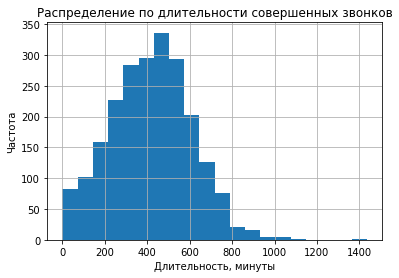

In [29]:
stat(data_smart, 'calls_duration')
plt.title('Распределение по длительности совершенных звонков')
plt.xlabel('Длительность, минуты')
plt.ylabel('Частота')
plt.show()

среднее 33.36905829596412
дисперсия = 796.5978766916688
стандартное отклонение = 28.230395954185852


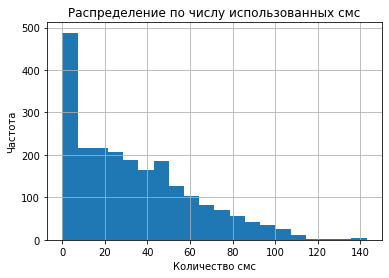

In [30]:
stat(data_smart, 'message_quantity')
plt.title('Распределение по числу использованных смс')
plt.xlabel('Количество смс')
plt.ylabel('Частота')
plt.show()

среднее 16221.910762331838
дисперсия = 34632985.84629673
стандартное отклонение = 5886.299627158955


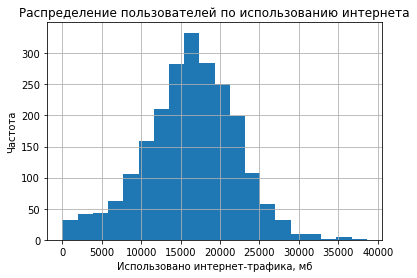

In [31]:
stat(data_smart, 'mb_used')
plt.title('Распределение пользователей по использованию интернета')
plt.xlabel('Использовано интернет-трафика, мб')
plt.ylabel('Частота')
plt.show()

среднее 526.0892494929006
дисперсия = 100950.00623331097
стандартное отклонение = 317.8875485911392


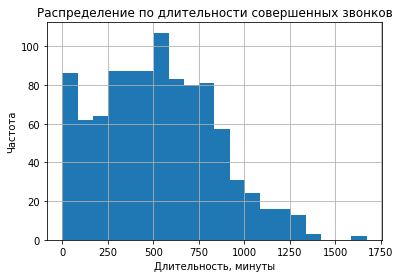

In [32]:
stat(data_ultra, 'calls_duration')
plt.title('Распределение по длительности совершенных звонков')
plt.xlabel('Длительность, минуты')
plt.ylabel('Частота')
plt.show()

среднее 49.31338742393509
дисперсия = 2283.0995570851965
стандартное отклонение = 47.80603962530092


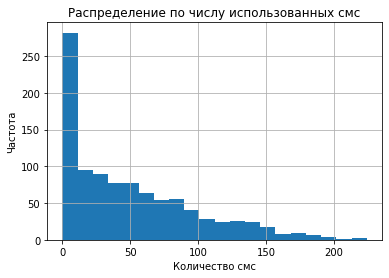

In [33]:
stat(data_ultra, 'message_quantity')
plt.title('Распределение по числу использованных смс')
plt.xlabel('Количество смс')
plt.ylabel('Частота')
plt.show()

среднее 19467.137931034482
дисперсия = 102113595.65034623
стандартное отклонение = 10110.255401095066


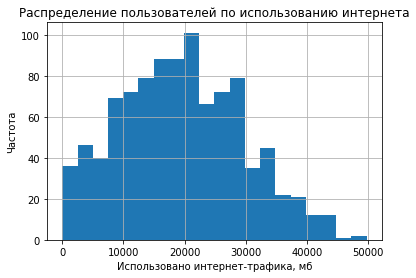

In [34]:
stat(data_ultra, 'mb_used')
plt.title('Распределение пользователей по использованию интернета')
plt.xlabel('Использовано интернет-трафика, мб')
plt.ylabel('Частота')
plt.show()

### Вывод
Представленые распределения не являются нормальными. У распределений наблюдается разная степень смещенности вправо, т.е число событий больше среднего значения меньше числа событий не превышающих его. Распределения для длительности звонков и использования интернета для тарифа smart имеют наибольшее смещение вправо и напоминают нормальные распределения, Распределения звонков и использования интернета для тарифа ultra, разница числа событий проявляется нагляднее, для сообщений у обоих распредений среднее значение близко к минимальному и большая часть абонентов использует минимальное значение смс. Распределения имеют вполне ожидаемый вид, например количество смс отправляемых в наше время, для большинства абонентов ожидаемо мало. 

## Шаг 4. Проверьте гипотезы

среднее 1233.0430318105382
дисперсия = 620105.4559088424
стандартное отклонение = 787.6443708027176


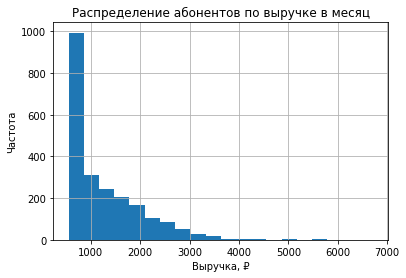

In [35]:
stat(data_smart, 'gain')
plt.title('Распределение абонентов по выручке в месяц')
plt.xlabel('Выручка, ₽')
plt.ylabel('Частота')
plt.show()

среднее 2060.417871688007
дисперсия = 126708.1514977096
стандартное отклонение = 356.14152975322344


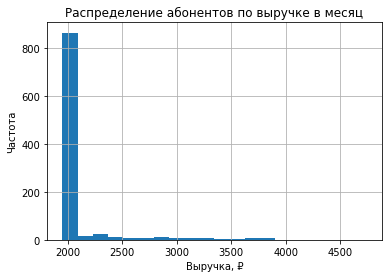

In [36]:
stat(data_ultra, 'gain')
plt.title('Распределение абонентов по выручке в месяц')
plt.xlabel('Выручка, ₽')
plt.ylabel('Частота')
plt.show()

In [37]:
alpha =.05
statist, pvalue = st.mannwhitneyu(data_smart['gain'], data_ultra['gain'], alternative = 'two-sided')
print('p-значение:', pvalue)
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.5558131082531575e-215
Отвергаем нулевую гипотезу


In [38]:
data_Moscow = data.query('city == "Москва"')

In [39]:
data_regions = data.query('city != "Москва"')

среднее 1481.8855588711613
дисперсия = 630195.2607344853
стандартное отклонение = 794.0008005054386


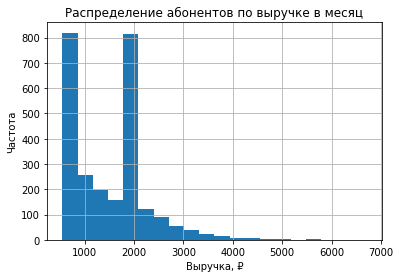

In [40]:
stat(data_regions, 'gain')
plt.title('Распределение абонентов по выручке в месяц')
plt.xlabel('Выручка, ₽')
plt.ylabel('Частота')
plt.show()

среднее 1507.276761968085
дисперсия = 546347.0989109281
стандартное отклонение = 739.7585754100788


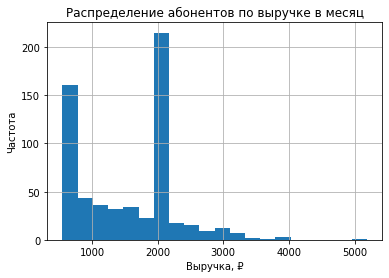

In [41]:
stat(data_Moscow, 'gain')
plt.title('Распределение абонентов по выручке в месяц')
plt.xlabel('Выручка, ₽')
plt.ylabel('Частота')
plt.show()

In [42]:
alpha =.05
statist, pvalue = st.mannwhitneyu(data_regions['gain'], data_Moscow['gain'], alternative = 'two-sided')
print('p-значение:', pvalue)
if (pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.2731140987843754
Не получилось отвергнуть нулевую гипотезу


### Вывод
Нулевые гипотезы, заданные в этой задаче : 1. Среднее выборки по тарифу smart равно среднему выборки по тарифу ultra. 2. Среднее выборки по абонентам из Москвы равно среднему выборки по абонентам не из Москвы.

Альтернативные: 1. Среднее выборки по тарифу smart не равно среднему выборки по тарифу ultra. 2. Среднее выборки по абонентам из Москвы не равно среднему выборки по абонентам не из Москвы. 

Для проверки данных гипотез использовался критерий Манна — Уитни, т.к. обе выборки не представляют из себя нормального распредения. Интуитивно представлялось, что для первого случая нулевая гипотеза неверная, а для второго наоборот, что и подтвердилось при проверке гипотез.

## Шаг 5. Общий вывод

По итогам исследования можно сделать выводы, о том что в целом количество использованных услуг в обоих тарифах отличается меньше, чем предполагается тарифными планами, по графикам выручки с пользователей видно, что процент людей, превысивших тарифные условия тарифа smart выше чем превысивших условия тарифа ultra. Тем не менее видно что выручки с обоих тарифов не равны между собой, что и подтвердилось проверкой гипотез. Также можно сказать что отличия по количеству использованных услуг в Москве и регионах мало отличаются друг от друга.